In [1]:
import emoji
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer

# Set visual style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print(" Libraries imported successfully.")

 Libraries imported successfully.


In [5]:
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load the training data (We focus on Train for EDA)
# Adjust path if needed (e.g., if you are running this locally vs Colab)
try:
    df = load_data('../data/train.jsonl')
    print(f"Data Loaded. Shape: {df.shape}")
    print("\nSample rows:")
    display(df.head())
except FileNotFoundError:
    print("File not found. Make sure you are in the correct directory (UTS2017_Bank).")

Data Loaded. Shape: (1977, 2)

Sample rows:


,text,sentiment
0,Cần tư vấn mà add k rep,negative
1,Hotline khó gọi quá gọi mãi ko thưa máy à,negative
2,Mình thấy câu dịch vụ tốt nhất cho kh khó lắm....,negative
3,Em chọn chuyển tiền trong nước. Chuyển đến số ...,negative
4,"Mình xài cái thể VISA của BIDV hạn mức 100tr, ...",negative


# **EDA**

## **1. Univariate Analysis**

In [6]:
# Calculate length (number of words) simply by splitting on whitespace
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Calculate character length
df['char_count'] = df['text'].apply(len)

C:\Users\tntdu\AppData\Local\Temp\ipykernel_17764\3866886214.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


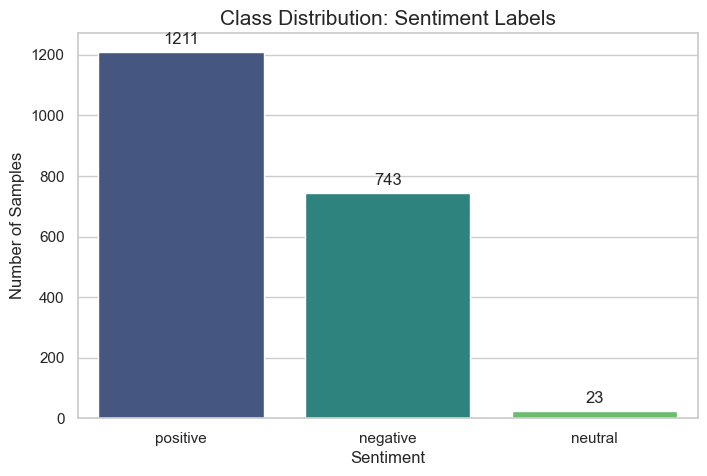

Class Percentages:
 sentiment
positive    61.254426
negative    37.582195
neutral      1.163379
Name: proportion, dtype: float64


In [9]:
# Calculate counts
sentiment_counts = df['sentiment'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

# Add labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.title("Class Distribution: Sentiment Labels", fontsize=15)
plt.ylabel("Number of Samples")
plt.xlabel("Sentiment")
plt.show()

# Print exact percentages
print("Class Percentages:\n", df['sentiment'].value_counts(normalize=True) * 100)

C:\Users\tntdu\AppData\Local\Temp\ipykernel_17764\4189609226.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=words_df, palette="magma")


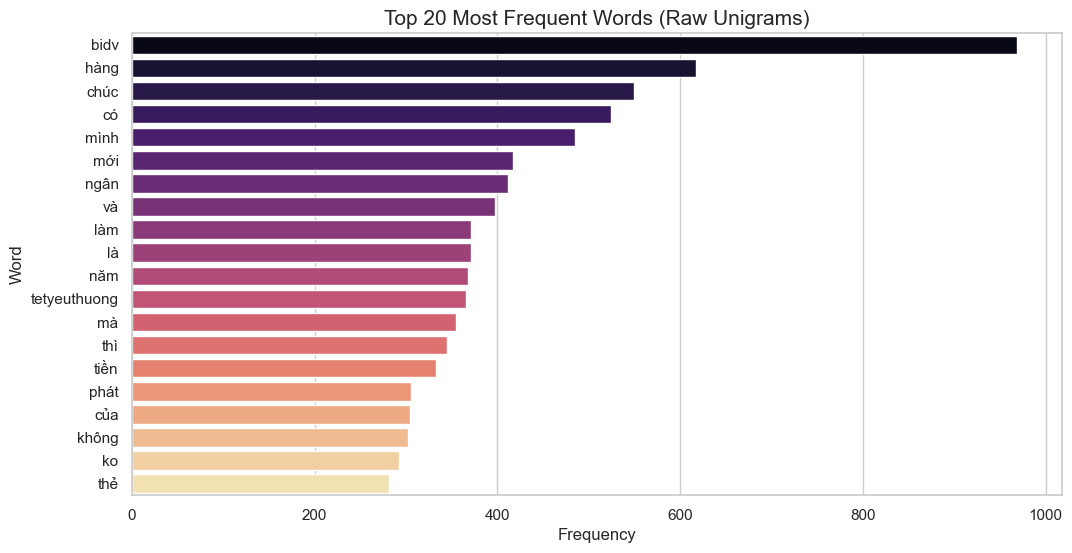

In [12]:
# Simple helper to clean and get words
def get_most_common_words(texts, n=20):
    all_words = " ".join(texts).lower()
    # Remove punctuation for cleaner counts
    all_words = re.sub(r'[^\w\s]', '', all_words) 
    words = all_words.split()
    return Counter(words).most_common(n)

# Get top 20 words
top_words = get_most_common_words(df['text'])
words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=words_df, palette="magma")
plt.title("Top 20 Most Frequent Words (Raw Unigrams)", fontsize=15)
plt.show()

Detected 17 Generic Stopwords (e.g., ['làm', 'hàng', 'được', 'có', 'mình']...)


C:\Users\tntdu\AppData\Local\Temp\ipykernel_17764\3361452529.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=data, ax=axes[i], palette=colors[i])
C:\Users\tntdu\AppData\Local\Temp\ipykernel_17764\3361452529.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=data, ax=axes[i], palette=colors[i])
C:\Users\tntdu\AppData\Local\Temp\ipykernel_17764\3361452529.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=data, ax=axes[i], palette=colors[i]

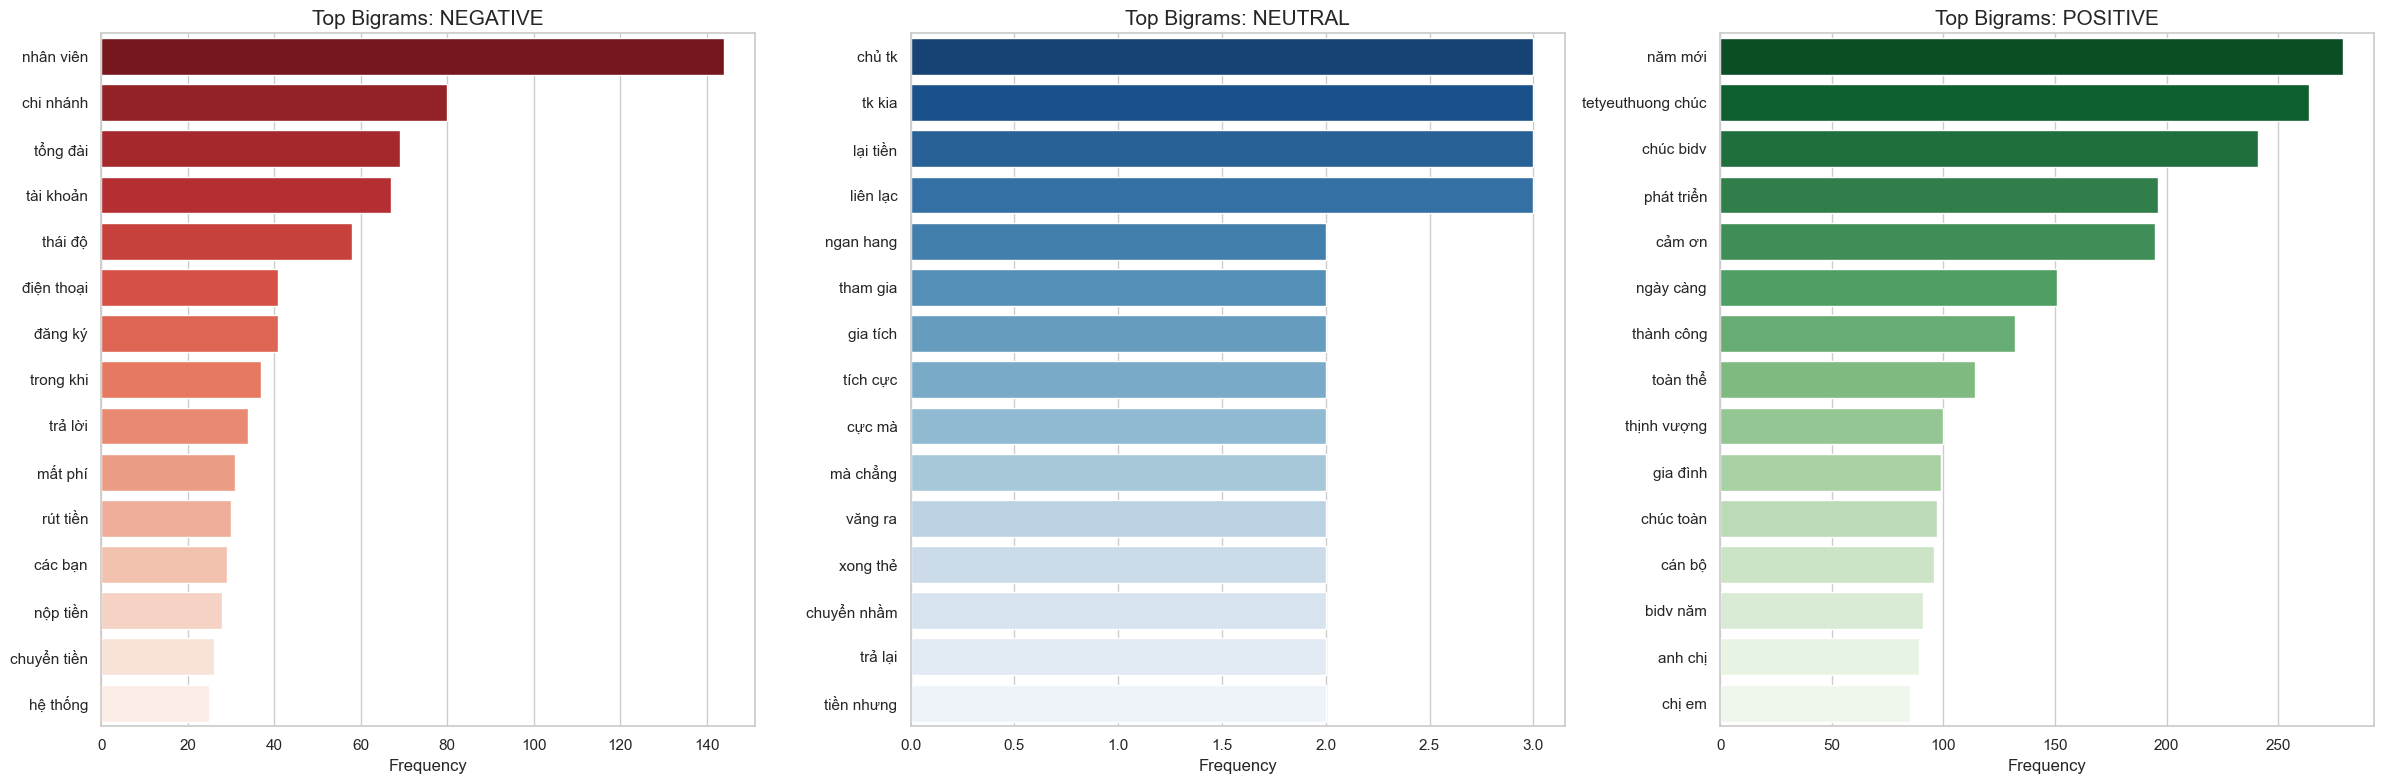

In [13]:
# --- 1. Identify "Generic Stopwords" (Intersection of all 3 classes) ---
def get_top_unigrams(texts, n=100):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(texts)
    sum_words = vec.transform(texts).sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return set([w[0] for w in sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]])

# Get top words for each class
top_neg = get_top_unigrams(df[df['sentiment']=='negative']['text'])
top_pos = get_top_unigrams(df[df['sentiment']=='positive']['text'])
top_neu = get_top_unigrams(df[df['sentiment']=='neutral']['text'])

# The Intersection: Words appearing in Top 100 of ALL classes are treated as Stopwords
generic_stopwords = list(top_neg.intersection(top_pos).intersection(top_neu))

print(f"Detected {len(generic_stopwords)} Generic Stopwords (e.g., {generic_stopwords[:5]}...)")


# --- 2. Helper Function to Get Bigrams (Excluding Stopwords) ---
def get_top_bigrams(texts, stop_words, n=10):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words).fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key = lambda x: x[1], reverse=True)[:n]


# --- 3. Visualization: Side-by-Side Comparison ---
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
sentiments = ['negative', 'neutral', 'positive']
colors = ['Reds_r', 'Blues_r', 'Greens_r']

for i, sentiment in enumerate(sentiments):
    # Get text for this specific sentiment
    subset_text = df[df['sentiment'] == sentiment]['text'].dropna()
    
    # Get Bigrams
    top_bigrams = get_top_bigrams(subset_text, generic_stopwords, n=15)
    data = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
    
    # Plot
    sns.barplot(x='Frequency', y='Bigram', data=data, ax=axes[i], palette=colors[i])
    axes[i].set_title(f"Top Bigrams: {sentiment.upper()}", fontsize=15)
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

## **2. Multivariate Analysis**

In [14]:
# --- ADDING NEW FEATURES FOR DEEPER ANALYSIS ---
import numpy as np

# 1. Average Word Length (Complexity check)
# Avoid division by zero
df['avg_word_len'] = df.apply(lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)

# 2. Punctuation Counts (Emotion indicators)
df['num_exclamations'] = df['text'].apply(lambda x: x.count('!'))
df['num_question_marks'] = df['text'].apply(lambda x: x.count('?'))

# 3. Emoji/Special Character Flag
# Checking for characters outside standard Vietnamese/English range can proxy for emojis
df['has_emoji'] = df['text'].apply(lambda x: 1 if re.search(r'[^\w\s,."\'-]', x) else 0)

print("New features created: avg_word_len, num_exclamations, num_question_marks, has_emoji")

New features created: avg_word_len, num_exclamations, num_question_marks, has_emoji


--- Detailed Univariate Statistics ---


,min,Q1,median,mean,Q3,max,std,mode
word_count,1.0,5.0,14.000000,23.806272,28.000000,816.0,39.612884,3.0
char_count,3.0,22.0,62.000000,106.263531,126.000000,3787.0,179.160003,14.0
avg_word_len,2.0,4.0,4.388889,4.353740,4.731707,9.0,0.708158,4.0
num_exclamations,0.0,0.0,0.000000,0.172484,0.000000,20.0,0.795414,0.0
num_question_marks,0.0,0.0,0.000000,0.110268,0.000000,39.0,1.076986,0.0


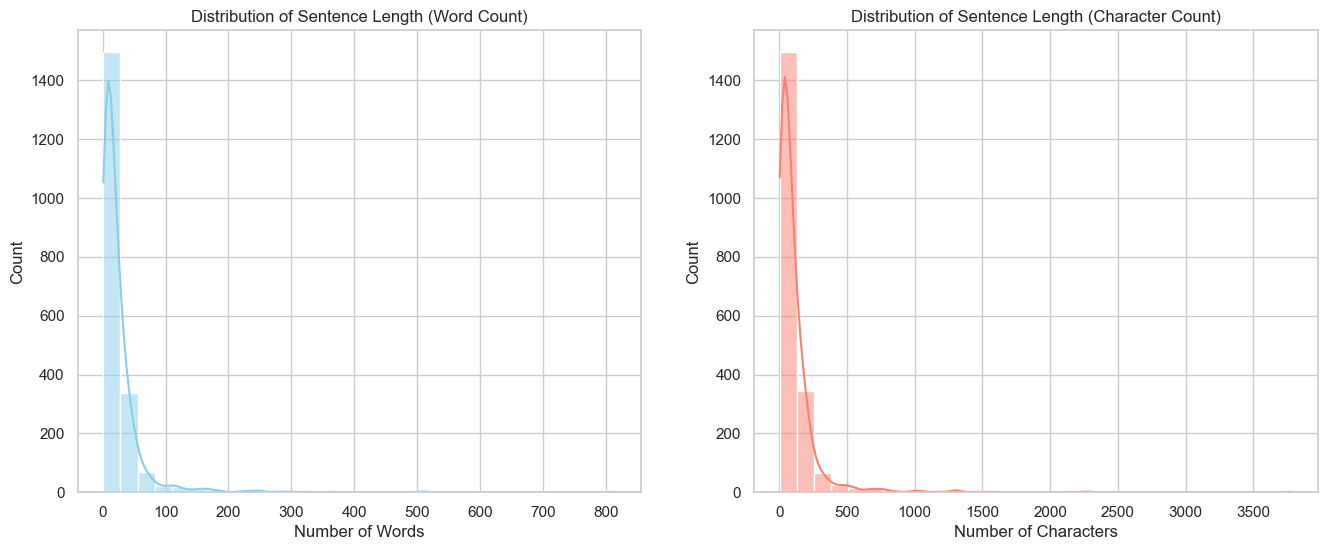

In [15]:
# Select only the numerical columns we are interested in
numeric_cols = ['word_count', 'char_count', 'avg_word_len', 'num_exclamations', 'num_question_marks']

# Get the standard descriptive statistics
stats_df = df[numeric_cols].describe().T

# Add Median and Mode specifically (describe() gives median as 50%, but let's be explicit)
stats_df['median'] = df[numeric_cols].median()
# Mode can be multiple, so we take the first one
stats_df['mode'] = df[numeric_cols].mode().iloc[0]

# Rename 25% and 75% to Q1 and Q3 for clarity
stats_df = stats_df.rename(columns={'25%': 'Q1', '75%': 'Q3'})

print("--- Detailed Univariate Statistics ---")
display(stats_df[['min', 'Q1', 'median', 'mean', 'Q3', 'max', 'std', 'mode']])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Word Count
sns.histplot(df['word_count'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Distribution of Sentence Length (Word Count)")
axes[0].set_xlabel("Number of Words")

# Plot Character Count
sns.histplot(df['char_count'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Distribution of Sentence Length (Character Count)")
axes[1].set_xlabel("Number of Characters")

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_10484\757379178.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='avg_word_len', data=df, ax=axes[0], palette="coolwarm")
C:\Users\User\AppData\Local\Temp\ipykernel_10484\757379178.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='num_exclamations', data=df, ax=axes[1], palette="coolwarm")
C:\Users\User\AppData\Local\Temp\ipykernel_10484\757379178.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='num_question_marks', data=df, ax=axes[2], 

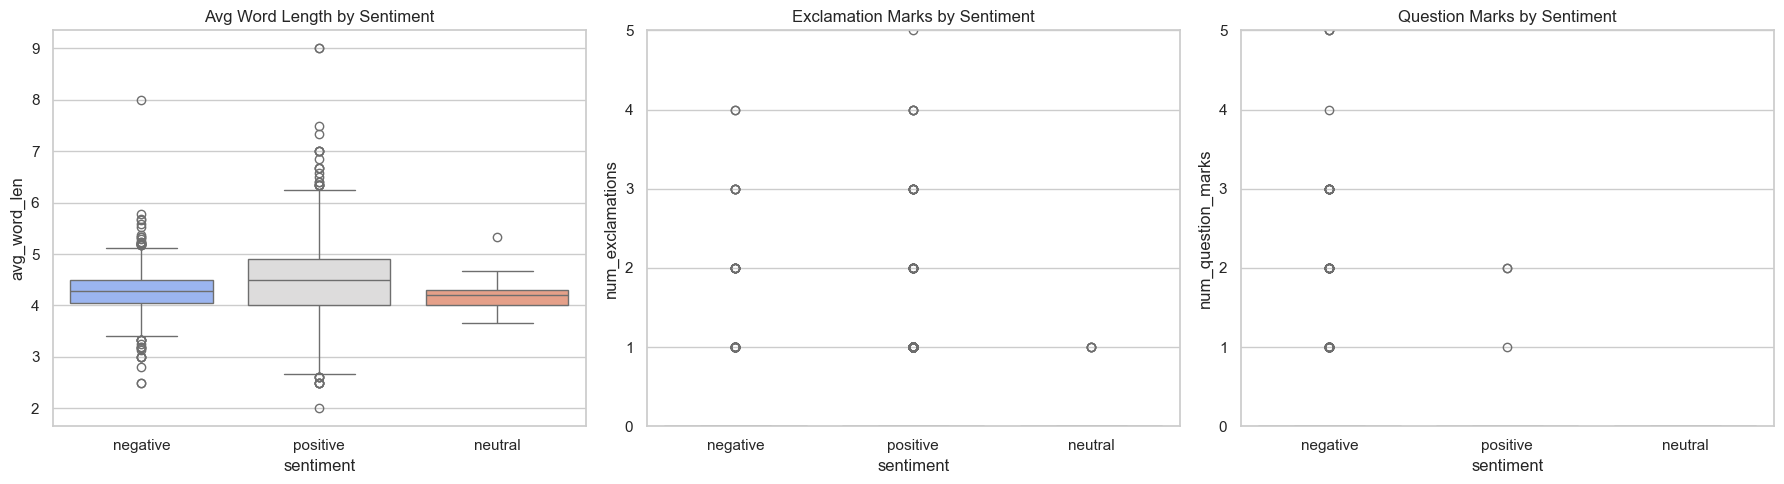

In [24]:
# 1. Boxplots for New Features vs Sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Avg Word Length
sns.boxplot(x='sentiment', y='avg_word_len', data=df, ax=axes[0], palette="coolwarm")
axes[0].set_title("Avg Word Length by Sentiment")

# Exclamation Marks
# We limit y-axis because outliers can squash the plot
sns.boxplot(x='sentiment', y='num_exclamations', data=df, ax=axes[1], palette="coolwarm")
axes[1].set_title("Exclamation Marks by Sentiment")
axes[1].set_ylim(0, 5) # Zoom in for better visibility

# Question Marks
sns.boxplot(x='sentiment', y='num_question_marks', data=df, ax=axes[2], palette="coolwarm")
axes[2].set_title("Question Marks by Sentiment")
axes[2].set_ylim(0, 5)

plt.tight_layout()
plt.show()

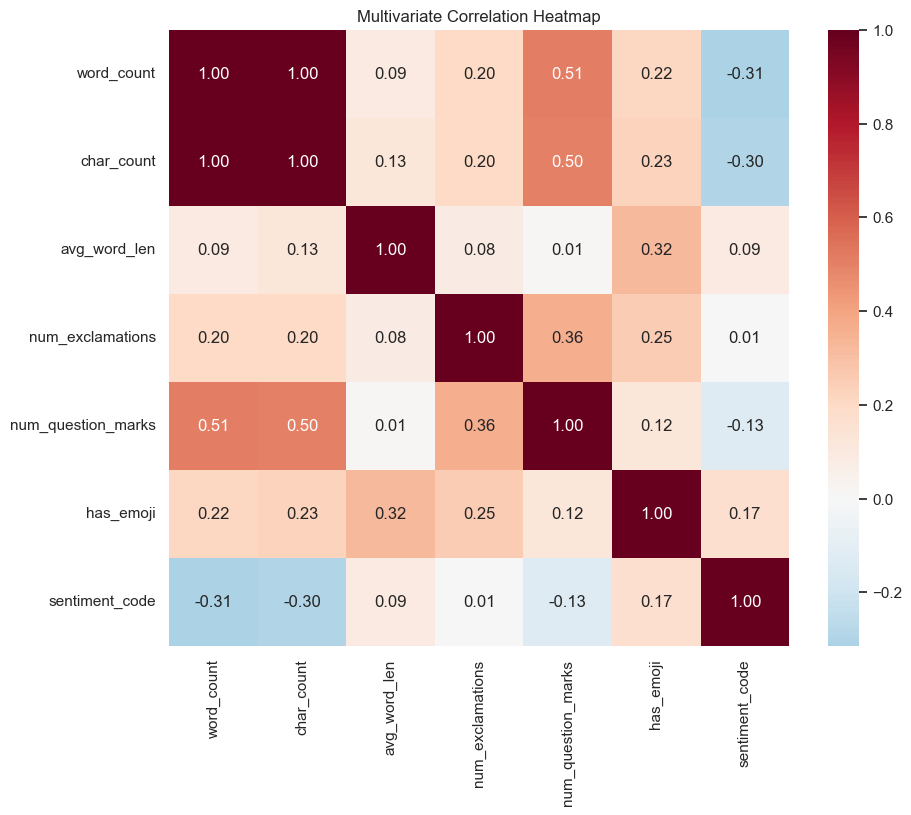

In [16]:
# Encode sentiment to numbers to include it in correlation
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_code'] = df['sentiment'].map(label_map)

# Correlation Matrix
corr_cols = ['word_count', 'char_count', 'avg_word_len', 
             'num_exclamations', 'num_question_marks', 'has_emoji', 'sentiment_code']

plt.figure(figsize=(10, 8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title("Multivariate Correlation Heatmap")
plt.show()

## **3. Emoji Analysis**

In [17]:
# 2. Does having an emoji make you Positive?
emoji_corr = pd.crosstab(df['has_emoji'], df['sentiment'], normalize='index') * 100
print("\n--- Emoji Presence vs Sentiment (%) ---")
display(emoji_corr)


--- Emoji Presence vs Sentiment (%) ---


sentiment,negative,neutral,positive
has_emoji,,,
0,44.551845,1.230228,54.217926
1,28.128725,1.072706,70.798570


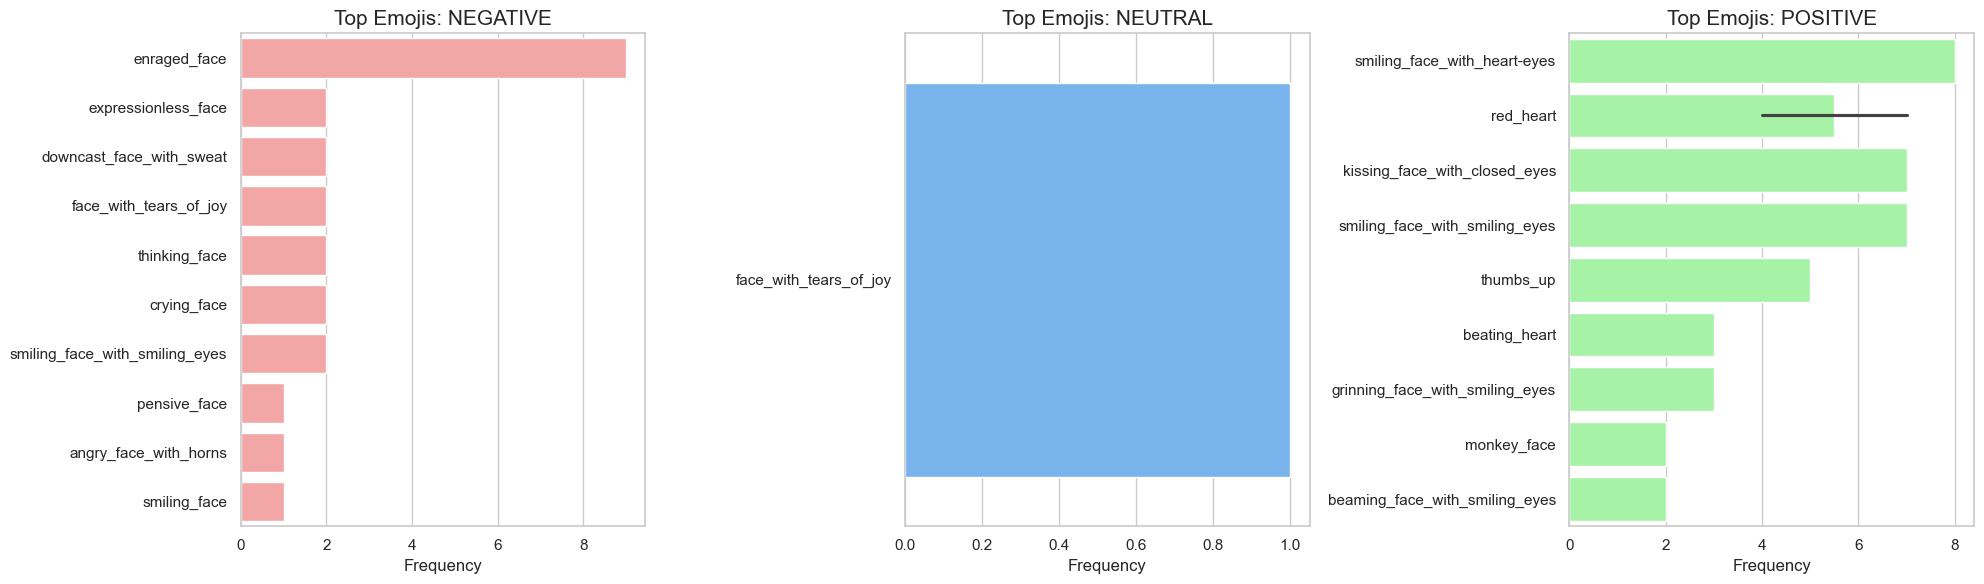


🧐 EMOJI LOOKUP TABLE (Icon vs Name)

--- NEGATIVE Class ---


,Emoji,Name,Frequency
0,😡,enraged_face,9
1,😑,expressionless_face,2
2,😓,downcast_face_with_sweat,2
3,😂,face_with_tears_of_joy,2
4,🤔,thinking_face,2
5,😢,crying_face,2
6,😊,smiling_face_with_smiling_eyes,2
7,😔,pensive_face,1
8,👿,angry_face_with_horns,1
9,☺,smiling_face,1




--- NEUTRAL Class ---


,Emoji,Name,Frequency
0,😂,face_with_tears_of_joy,1




--- POSITIVE Class ---


,Emoji,Name,Frequency
0,😍,smiling_face_with_heart-eyes,8
1,❤️,red_heart,7
2,😚,kissing_face_with_closed_eyes,7
3,😊,smiling_face_with_smiling_eyes,7
4,👍,thumbs_up,5
5,❤,red_heart,4
6,💓,beating_heart,3
7,😄,grinning_face_with_smiling_eyes,3
8,🐵,monkey_face,2
9,😁,beaming_face_with_smiling_eyes,2


In [18]:
# --- 1. Extraction Function ---
def get_raw_emojis(text):
    # distinct_emoji_list returns the actual icons like '😊'
    return emoji.distinct_emoji_list(str(text))

# --- 2. Process Data ---
sentiments = ['negative', 'neutral', 'positive']
emoji_stats = {}

for sent in sentiments:
    texts = df[df['sentiment'] == sent]['text']
    all_icons = []
    
    # Collect all raw emojis first
    for t in texts:
        all_icons.extend(get_raw_emojis(t))
    
    # Get top 10 most common raw emojis
    top_10_raw = Counter(all_icons).most_common(10)
    
    # Create a mini dataset for this sentiment
    data = []
    for icon, freq in top_10_raw:
        # Save both the Icon and the Name
        name = emoji.demojize(icon).replace(":", "") # Remove colons for clean look
        data.append({'Emoji': icon, 'Name': name, 'Frequency': freq})
        
    emoji_stats[sent] = pd.DataFrame(data)

# --- 3. Visualization (Bar Charts) ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
colors = ['#ff9999', '#66b3ff', '#99ff99']

for i, sent in enumerate(sentiments):
    df_sent = emoji_stats[sent]
    
    if df_sent.empty:
        axes[i].text(0.5, 0.5, "No Emojis Found", ha='center')
        axes[i].set_title(f"{sent.upper()}", fontsize=14)
        continue
    
    # Plot using the 'Name' (Text)
    sns.barplot(x='Frequency', y='Name', data=df_sent, ax=axes[i], color=colors[i])
    axes[i].set_title(f"Top Emojis: {sent.upper()}", fontsize=15)
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

# --- 4. The Lookup Table Display ---
print("\n" + "="*60)
print("🧐 EMOJI LOOKUP TABLE (Icon vs Name)")
print("="*60 + "\n")

# Display tables side-by-side (using a loop for clarity in the notebook output)
for sent in sentiments:
    print(f"--- {sent.upper()} Class ---")
    if not emoji_stats[sent].empty:
        # We display the DataFrame which renders nicely in Jupyter
        display(emoji_stats[sent])
    else:
        print("No emojis found.")
    print("\n")

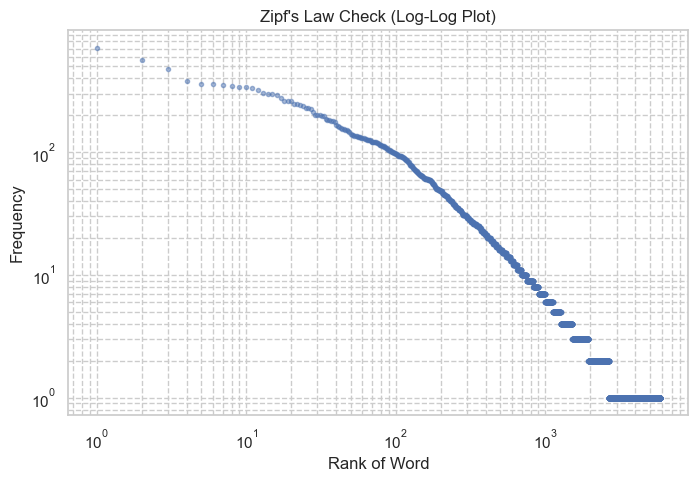


--- Top Used Emojis ---
[('❤', 24), ('😡', 21), ('😍', 18), ('👍', 15), ('😊', 12), ('😂', 8), ('🌸', 3), ('😓', 2), ('☺', 1), ('😭', 1)]


In [28]:
# --- 1. Zipf's Law Check (Log-Log Plot) ---
# If the line is straight (roughly linear descent), it follows natural language properties.
all_tokens = " ".join(df['text']).split()
token_counts = Counter(all_tokens).most_common()
ranks = np.arange(1, len(token_counts) + 1)
frequencies = [x[1] for x in token_counts]

plt.figure(figsize=(8, 5))
plt.loglog(ranks, frequencies, marker=".", linestyle='none', alpha=0.5)
plt.title("Zipf's Law Check (Log-Log Plot)")
plt.xlabel("Rank of Word")
plt.ylabel("Frequency")
plt.grid(True, which="both", ls="--")
plt.show()

# --- 2. Extracting Specific Emojis ---
# Simple extractor for common emojis
def extract_emojis(text):
    return [c for c in text if c in set("😊👍😞😡😭😍❤💔☺🙂😂😒😓🌸")]

df['emojis'] = df['text'].apply(extract_emojis)
all_emojis = [e for sublist in df['emojis'] for e in sublist]

if all_emojis:
    print("\n--- Top Used Emojis ---")
    print(Counter(all_emojis).most_common(10))
else:
    print("\nNo common emojis found in this subset.")

## **4. Noise Analysis**

In [19]:
# 1. Check for Duplicates (Bots/Spam)
num_dupes = df.duplicated(subset=['text']).sum()
print(f"⚠️ Duplicate Rows Found: {num_dupes}")
if num_dupes > 0:
    print("   -> We must remove these in preprocessing to avoid bias.")

# 2. Check for Teencode (Common abbreviations)
teencode_list = [' k ', ' ko ', ' ko ', ' dc ', ' đc ', ' hok ', ' ak ', ' uhm ']
print("\n⚠️ Teencode Presence Check:")
for word in teencode_list:
    count = df['text'].str.contains(word, regex=False).sum()
    print(f"   - '{word.strip()}': appears {count} times")

print("\n   -> Action: We need a dictionary to map these to standard Vietnamese.")

⚠️ Duplicate Rows Found: 111
   -> We must remove these in preprocessing to avoid bias.

⚠️ Teencode Presence Check:
   - 'k': appears 88 times
   - 'ko': appears 181 times
   - 'ko': appears 181 times
   - 'dc': appears 35 times
   - 'đc': appears 53 times
   - 'hok': appears 1 times
   - 'ak': appears 1 times
   - 'uhm': appears 0 times

   -> Action: We need a dictionary to map these to standard Vietnamese.


In [20]:
# --- FINAL DATA HYGIENE CHECK ---
import re

print("="*40)
print(" DATA HYGIENE REPORT")
print("="*40)

# 1. Check for HTML Tags or URLs (Scraping artifacts)
html_tags = df['text'].str.contains(r'<[^>]+>', regex=True).sum()
urls = df['text'].str.contains(r'http\S+|www\.\S+', regex=True).sum()
print(f"• HTML Tags detected: {html_tags} rows")
print(f"• URLs detected: {urls} rows")
if html_tags > 0 or urls > 0:
    print("  -> ACTION: Remove these via regex in preprocessing.")

# 2. Check for Non-Vietnamese Characters (e.g., Chinese, Korean, Cyrillic)
# This regex matches anything that is NOT Latin (A-Z), Vietnamese, numbers, or punctuation.
garbage_chars = df[df['text'].str.contains(r'[^\w\s,.;?!@%&\(\)\"\'+-]', regex=True)]
print(f"• Rows with potential 'strange' characters: {len(garbage_chars)}")
if len(garbage_chars) > 0:
    print(f"  -> Example: {garbage_chars['text'].iloc[0]}")

# 3. Duplicate Content Inspection (Bot Check)
# We want to see the CONTENT of the duplicates, not just the count.
dupes = df['text'].value_counts()
heavy_dupes = dupes[dupes > 1] # sentences appearing more than once

print(f"\n• Repeated Sentences (Potential Spam/Templates): {len(heavy_dupes)}")
if len(heavy_dupes) > 0:
    print("  Top 3 most repeated sentences:")
    for text, count in heavy_dupes.head(3).items():
        print(f"    ({count}x): {text[:50]}...")
        
    print("  -> INSIGHT: If these are 'Thank you', keep them. If 'Buy crypto', remove them.")

 DATA HYGIENE REPORT
• HTML Tags detected: 0 rows
• URLs detected: 5 rows
  -> ACTION: Remove these via regex in preprocessing.
• Rows with potential 'strange' characters: 593
  -> Example: Mình thấy câu dịch vụ tốt nhất cho kh khó lắm. Mình nộp tiền vào 15/07/2017 mà hôm nay thấy sai sai muốn xem lại bản kê từng loại tiền mà thu ngân lại nói đã huỷ hết chứng từ, vậy nên mình đang thiếu 1 tr chắc phải bù vậy. Một tuần làm việc ... Buồn

• Repeated Sentences (Potential Spam/Templates): 55
  Top 3 most repeated sentences:
    (9x): # Tetyeuthuong Chúc toàn thể cán bộ, anh chị em BI...
    (7x): # Tetyeuthuong Năm mới xin chúc tất cả cán bộ, anh...
    (7x): #Tetyeuthuong Chúc tết an lành . Chúc toàn thể các...
  -> INSIGHT: If these are 'Thank you', keep them. If 'Buy crypto', remove them.
